In [1]:
# Imports
import numpy as np
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
from master_data_functions.functions import *
from keras import backend
%load_ext autoreload
%autoreload 2


/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'

In [2]:
# Load data
DATA_PATH = "../../data/simulated/"
OUTPUT_PATH = "../../data/output/"
MODEL_PATH = OUTPUT_PATH + "models/"


# Images are NOT normalized, positions are normalized (div by 16) to [0,1] interal
images = np.load(DATA_PATH + "test_images_1M.npy")
energies = np.load(DATA_PATH + "test_energies_1M.npy")
positions = np.load(DATA_PATH + "test_positions_1M.npy")

# shape is (x1, y1, x2, y2, E1, E2)
y_pred = np.load(DATA_PATH + "test_y_pred_1M.npy")
targets = np.concatenate((positions, energies), axis=1)


print("Images shape: {}".format(images.shape))
print("Energies shape: {}".format(energies.shape))
print("Positions shape: {}".format(positions.shape))
print("Targets shape: {}".format(targets.shape))
print("Predictions shape: {}".format(y_pred.shape))

Images shape: (200000, 16, 16, 1)
Energies shape: (200000, 2)
Positions shape: (200000, 4)
Targets shape: (200000, 6)
Predictions shape: (200000, 6)


In [3]:
# Custom functions
# Define R2 score in numpy
eps = 1e-13
def r2_score(y_true, y_pred):
    SS_res =  np.sum(np.square(y_true - y_pred))
    SS_tot = np.sum(np.square(y_true - np.mean(y_true)))
    return ( 1 - SS_res/(SS_tot + eps) )


## Numbers

In [82]:
# Statistics about the data
single, double, close = event_indices(positions*16*3) #scale to mm

print("Number of single events:", len(single))
print("Number of double events:", len(double))
print("Number of close events:", len(close))

print()
# Get some numbers about the residuals for double events
y_resid = targets - y_pred

print("X1 residuals mean: {:g}".format(np.mean(y_resid[double,0])))
print("Y1 residuals mean: {:g}".format(np.mean(y_resid[double,1])))
print("X2 residuals mean: {:g}".format(np.mean(y_resid[double,2])))
print("Y2 residuals mean: {:g}".format(np.mean(y_resid[double,3])))
print("E1 residuals mean: {:g}".format(np.mean(y_resid[double,4])))
print("E2 residuals mean: {:g}".format(np.mean(y_resid[double,5])))
print()
# Individual R2-scores for each target for double events
print("X1 r2 = {:g}".format(r2_score(targets[double, 0], y_pred[double, 0])))
print("Y1 r2 = {:g}".format(r2_score(targets[double, 1], y_pred[double, 1])))
print("X2 r2 = {:g}".format(r2_score(targets[double, 2], y_pred[double, 2])))
print("Y2 r2 = {:g}".format(r2_score(targets[double, 3], y_pred[double, 3])))
print("E1 r2 = {:g}".format(r2_score(targets[double, 4], y_pred[double, 4])))
print("E2 r2 = {:g}".format(r2_score(targets[double, 5], y_pred[double, 5])))

print("Single events r2:", r2_score(targets[single], y_pred[single]))
print("Double events r2:", r2_score(targets[double], y_pred[double]))

Number of single events: 99913
Number of double events: 100087
Number of close events: 435

X1 residuals mean: 0.0166316
Y1 residuals mean: 0.0206108
X2 residuals mean: 0.0654167
Y2 residuals mean: 0.0685886
E1 residuals mean: -0.00673573
E2 residuals mean: 0.0282819

X1 r2 = 0.47432
Y1 r2 = 0.47101
X2 r2 = -0.622689
Y2 r2 = -0.613922
E1 r2 = 0.426219
E2 r2 = 0.421784
Single events r2: 0.9857562493131922
Double events r2: 0.11201406485032195


## Plots
### Residuals

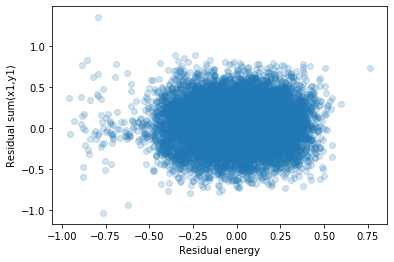

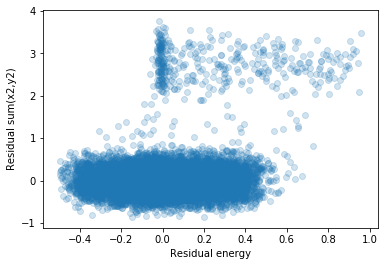

In [7]:
indices = np.random.choice(double, 10000, replace=False)
rel_dist = relative_distance(positions)
rel_E = relative_energy(energies)
# Residuals in pos 1 vs residuals in energy 1
fig, ax = plt.subplots(1,2, figsize=(12,6))
pos1_resid = np.sum(y_resid[:, :2], axis=1)
plt.scatter(y_resid[indices, 4], pos1_resid[indices], alpha=0.2)
plt.xlabel("Residuals - energy")
plt.ylabel("Residuals - sum(x1,y1)")
plt.show()

# Residuals in pos 2 vs residuals in energy 2
pos2_resid = np.sum(y_resid[:, 2:4], axis=1)
plt.scatter(y_resid[indices, 5], pos2_resid[indices], alpha=0.2)
plt.xlabel("Residuals - energy")
plt.ylabel("Residuals - sum(x2,y2)")
plt.show()

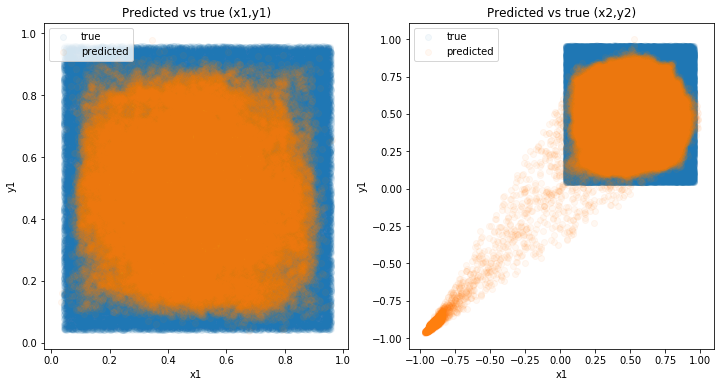

In [81]:
# Scatterplot predicted positions and target positions
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].scatter(targets[double,0], targets[double,1], alpha=0.05, label="true")
ax[0].scatter(y_pred[double,0], y_pred[double,1], alpha=0.05, label="predicted")
ax[0].set_title("Predicted vs true (x1,y1)")
ax[0].set_xlabel("x1")
ax[0].set_ylabel("y1")
ax[0].legend()

ax[1].scatter(targets[double,2], targets[double,3], alpha=0.05, label="true")
ax[1].scatter(y_pred[double,2], y_pred[double,3], alpha=0.05, label="predicted")
ax[1].set_title("Predicted vs true (x2,y2)")
ax[1].set_xlabel("x1")
ax[1].set_ylabel("y1")
ax[1].legend()
plt.show()




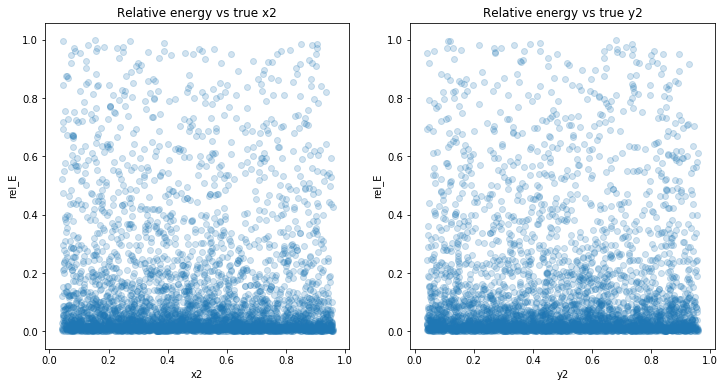

In [74]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].scatter(targets[pos_negative, 2], rel_E[pos_negative], alpha=0.2)
ax[0].set_title("Relative energy vs true x2")
ax[0].set_xlabel("x2")
ax[0].set_ylabel("rel_E")

ax[1].scatter(targets[pos_negative, 3], rel_E[pos_negative], alpha=0.2)
ax[1].set_title("Relative energy vs true y2")
ax[1].set_xlabel("y2")
ax[1].set_ylabel("rel_E")
plt.show()

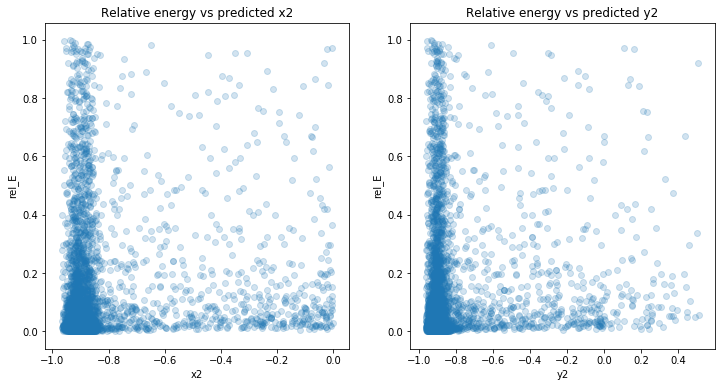

In [78]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].scatter(y_pred[pos_negative, 2], rel_E[pos_negative], alpha=0.2)
ax[0].set_title("Relative energy vs predicted x2")
ax[0].set_xlabel("x2")
ax[0].set_ylabel("rel_E")

ax[1].scatter(y_pred[pos_negative, 3], rel_E[pos_negative], alpha=0.2)
ax[1].set_title("Relative energy vs predicted y2")
ax[1].set_xlabel("y2")
ax[1].set_ylabel("rel_E")
plt.show()



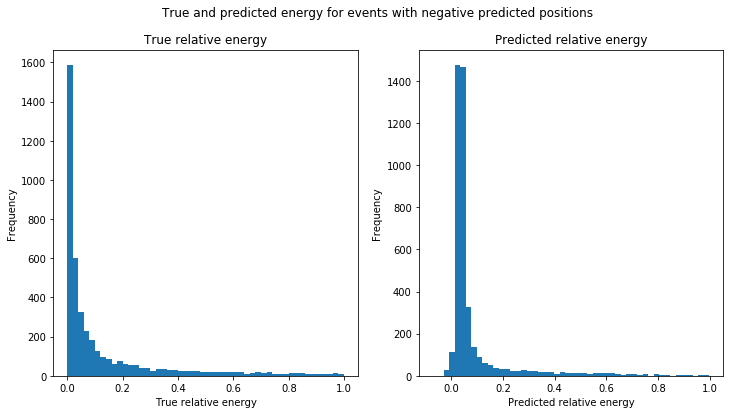

In [80]:
pred_rel_E = relative_energy(y_pred[:,4:])

fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].hist(rel_E[pos_negative], bins=50)
ax[0].set_title("True relative energy")
ax[0].set_xlabel("True relative energy")
ax[0].set_ylabel("Frequency")
ax[1].hist(pred_rel_E[pos_negative], bins=50)
ax[1].set_title("Predicted relative energy")
ax[1].set_xlabel("Predicted relative energy")
ax[1].set_ylabel("Frequency")
#ax[2].hist(y_pred[pos_negative, 5], bins=20)
#ax[2].set_title("Predicted E2")
#ax[2].set_xlabel("Predicted E2")
#ax[2].set_ylabel("Frequency")
fig.suptitle("True and predicted energy for events with negative predicted positions")
plt.show()

In [51]:
# Extract indices of events where sum of residuals of position 2 is greater than threshold

pos2_large = np.where(pos2_resid[indices] > 2)[0]
print(len(pos2_large))



439
